In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from gap_statistic import OptimalK
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
import os
import glob

In [2]:
# Read in the PCA dataset and set the index
df = pd.read_csv('full_dataset_with_PCA.csv')
df.set_index(['Season', 'Player'], inplace=True)

In [3]:
df

PC1       PC2       PC3       PC4       PC5
Season Player                                                          
2001   A.C. Green      0.731723 -1.297794 -1.701517  1.693110  1.330470
       A.J. Guyton    -2.892228 -1.521408 -1.135181  0.713153  0.375435
       Aaron McKie    -1.917119  0.679172  0.410573  0.731380  0.600381
       Aaron Williams  3.583582  0.397426  0.042290  0.476243 -0.248848
       Adam Keefe      1.225871 -1.549828 -0.667852  0.542559  1.060138
...                         ...       ...       ...       ...       ...
2019   Zaza Pachulia   3.087243  0.275098  1.130487  1.226967  0.730044
       Zhaire Smith   -0.909462 -1.079707  0.809244 -0.791178 -0.581445
       Zhou Qi         3.038855  2.385574 -2.135677 -5.924793 -0.698782
       Álex Abrines   -2.336488 -3.224558  0.350052 -1.208737 -1.252402
       Ángel Delgado   3.282497 -0.678330  0.824750 -0.845540  0.856803

[8870 rows x 5 columns]

In [4]:
# Drop the indexes and convert DataFrame to NumPy array
pca_data = df.reset_index(drop=True)
data_array = pca_data.values

def optimalK(data, max_clusters):
    results = []  # List to hold results
    
    nrefs=5
    gaps = np.zeros((len(range(1, max_clusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    
    # Get the min and max for each feature in your actual data
    mins = np.min(data, axis=0)
    maxs = np.max(data, axis=0)
    
    for gap_index, k in enumerate(range(1, max_clusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.uniform(mins, maxs, size=data.shape)
            
            # Fit to it
            ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
            clusters = ward.fit_predict(randomReference)
            
            # Calculate centroids for each cluster
            centroids = np.array([randomReference[clusters == j].mean(axis=0) for j in range(k)])

            # Calculate the sum of squared distances
            _, distances = pairwise_distances_argmin_min(randomReference, centroids)
            ward_inertia = np.sum(distances ** 2)
            
            refDisp = ward_inertia
            refDisps[i] = refDisp
        
        # Fit cluster to original data and create dispersion
        ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
        clusters = ward.fit_predict(data)
        
        # Calculate centroids for each cluster
        centroids = np.array([data[clusters == j].mean(axis=0) for j in range(k)])

        # Calculate the sum of squared distances
        _, distances = pairwise_distances_argmin_min(data, centroids)
        ward_inertia = np.sum(distances ** 2)
        
        origDisp = ward_inertia
        
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        results.append({'clusterCount': k, 'gap': gap})  # Append the results to the list
        resultsdf = pd.DataFrame(results)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

In [5]:
k, gapdf = optimalK(data_array, max_clusters=25)
print('Optimal k is: ', k)

Optimal k is:  9


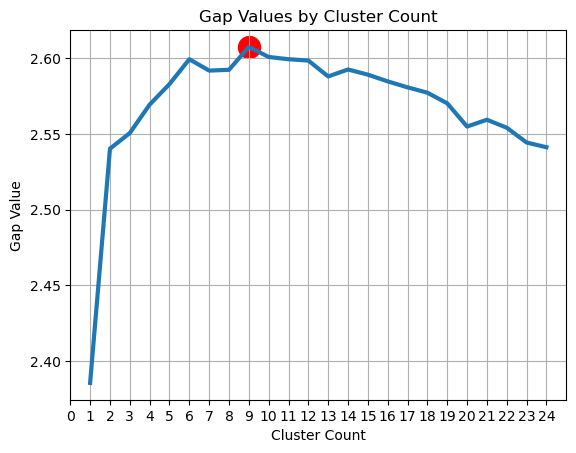

In [6]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlim(0, max(gapdf.clusterCount + 1))
plt.xticks(np.arange(0, max(gapdf.clusterCount) + 1, 1))
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [7]:
values = df.values

# Create the model
n_clusters = 10
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Fit the model
cluster_labels = clustering.fit_predict(values)

# Assign clusters back to the df
df['Cluster'] = cluster_labels + 1

In [8]:
df

PC1       PC2       PC3       PC4       PC5  \
Season Player                                                             
2001   A.C. Green      0.731723 -1.297794 -1.701517  1.693110  1.330470   
       A.J. Guyton    -2.892228 -1.521408 -1.135181  0.713153  0.375435   
       Aaron McKie    -1.917119  0.679172  0.410573  0.731380  0.600381   
       Aaron Williams  3.583582  0.397426  0.042290  0.476243 -0.248848   
       Adam Keefe      1.225871 -1.549828 -0.667852  0.542559  1.060138   
...                         ...       ...       ...       ...       ...   
2019   Zaza Pachulia   3.087243  0.275098  1.130487  1.226967  0.730044   
       Zhaire Smith   -0.909462 -1.079707  0.809244 -0.791178 -0.581445   
       Zhou Qi         3.038855  2.385574 -2.135677 -5.924793 -0.698782   
       Álex Abrines   -2.336488 -3.224558  0.350052 -1.208737 -1.252402   
       Ángel Delgado   3.282497 -0.678330  0.824750 -0.845540  0.856803   

                       Cluster  
Season Player                   
2001   A.C. Green            3  
       A.J. Guyton           4  
       Aaron McKie           1  
       Aaron Williams        5  
       Adam Keefe            3  
...                        ...  
2019   Zaza Pachulia         5  
       Zhaire Smith         10  
       Zhou Qi               6  
       Álex Abrines          4  
       Ángel Delgado         7  

[8870 rows x 6 columns]

In [9]:
# Read in the raw data to analyze how the averages for different clusters
pre_pca = pd.read_csv('full_dataset_before_PCA.csv')
pre_pca.set_index(['Season', 'Player'], inplace=True)
pre_pca['Cluster'] = cluster_labels + 1

In [10]:
# Sort by cluster to see the median value of each statistic for each cluster
cluster_medians = pre_pca.reset_index(drop=True).groupby('Cluster').median()

In [11]:
cluster_medians

,USG%,FGA,Personal Fouls Committed,BLK,STL,DRB,ORB,TOV,AST,% of FG Ast'd - 3P,% of FG Ast'd - 2P,FTr,Shooting Fouls Drawn,Corner 3s - %3PA,% of FGA by Distance - 3P,% of FGA by Distance - 16-3P,% of FGA by Distance - 10-16,% of FGA by Distance - 3-10,% of FGA by Distance - 0-3,Dunks - %FGA
Cluster,,,,,,,,,,,,,,,,,,,,
1,17.8,14.400000,3.857128,0.246871,1.662678,3.840000,0.786480,2.901368,6.472029,0.8035,0.3430,0.1980,1.020155,0.1980,0.3355,0.226,0.089,0.094,0.200,0.000
2,24.8,20.033533,3.450189,0.359102,1.880509,4.403591,1.010020,3.953395,7.938535,0.6640,0.2530,0.3150,2.373234,0.1230,0.2620,0.179,0.103,0.137,0.281,0.007
3,14.8,12.093750,5.843478,1.001739,1.210762,6.400000,3.068852,2.083472,2.093356,0.0000,0.7270,0.2330,1.156627,0.0000,0.0090,0.333,0.176,0.130,0.284,0.033
4,15.7,14.000000,3.889389,0.461135,1.225673,4.768559,1.004651,1.714286,2.644311,0.9620,0.6400,0.1500,0.777778,0.3330,0.4910,0.188,0.070,0.067,0.150,0.010
5,16.5,12.643902,6.241373,1.990909,1.078519,8.285178,4.504459,2.588764,1.637795,0.0000,0.6500,0.3770,2.080495,0.0000,0.0000,0.066,0.105,0.255,0.518,0.114
6,23.4,18.737349,4.800000,1.452973,1.143830,8.529892,3.693913,3.116324,2.584615,0.5000,0.6300,0.3410,2.926419,0.0830,0.0120,0.200,0.158,0.222,0.341,0.063
7,16.5,13.211650,4.961485,1.182609,1.491429,6.998131,3.278049,2.378801,2.456172,1.0000,0.6590,0.3340,1.964194,0.3700,0.1290,0.124,0.066,0.145,0.450,0.104
8,24.0,19.682209,3.600515,0.513999,1.465373,5.163902,1.443013,3.083430,4.132449,0.8820,0.4785,0.2975,2.436784,0.2385,0.2145,0.242,0.124,0.125,0.259,0.026
9,13.3,9.074352,6.602346,2.005341,1.240441,8.515578,5.066394,2.391780,1.340041,0.0000,0.6670,0.6190,2.406332,0.0000,0.0000,0.020,0.036,0.182,0.720,0.221


In [86]:
pre_pca.loc[(2015, "Kyle Korver")]

USG%                            14.400000
FGA                             11.910670
Personal Fouls Committed         2.828784
BLK                              0.893300
STL                              1.042184
DRB                              5.806452
ORB                              0.297767
TOV                              2.084367
AST                              3.870968
% of FG Ast'd - 3P               0.964000
% of FG Ast'd - 2P               0.915000
FTr                              0.197000
Shooting Fouls Drawn             0.516129
Corner 3s - %3PA                 0.247000
% of FGA by Distance - 3P        0.748000
% of FGA by Distance - 16-3P     0.148000
% of FGA by Distance - 10-16     0.035000
% of FGA by Distance - 3-10      0.022000
% of FGA by Distance - 0-3       0.047000
Dunks - %FGA                     0.005000
Cluster                          4.000000
Name: (2015, Kyle Korver), dtype: float64

In [94]:
pre_pca[pre_pca['Cluster'] == 6]

USG%        FGA  Personal Fouls Committed       BLK  \
Season Player                                                                   
2001   Al Harrington      18.8  13.852008                  5.738689  0.395772   
       Alan Henderson     22.6  17.810387                  4.259006  0.774365   
       Alonzo Mourning    30.6  22.023529                  3.670588  4.894118   
       Anthony Mason      20.0  14.043024                  3.422250  0.354026   
       Antonio McDyess    26.5  21.830137                  4.076712  1.972603   
...                        ...        ...                       ...       ...   
2019   Terrence Jones     47.2  38.400000                  9.600000  0.000000   
       Tyler Davis        40.7  48.000000                  0.000000  0.000000   
       Tyler Zeller       20.1  15.483871                 10.219355  1.548387   
       Willy Hernangómez  22.1  17.485714                  5.828571  1.028571   
       Zhou Qi            43.4  48.000000                  0.000000  0.000000   

                               STL        DRB        ORB       TOV       AST  \
Season Player                                                                  
2001   Al Harrington      1.583087   6.728118   2.968288  3.759831  3.364059   
       Alan Henderson     1.355138   6.001326   4.839779  3.291050  1.355138   
       Alonzo Mourning    0.611765  10.400000   5.505882  4.486275  1.835294   
       Anthony Mason      1.180086   8.850645   2.478181  2.596189  3.658267   
       Antonio McDyess    0.789041  11.309589   4.471233  3.024658  2.761644   
...                            ...        ...        ...       ...       ...   
2019   Terrence Jones     0.000000  38.400000   0.000000  9.600000  0.000000   
       Tyler Davis        0.000000   0.000000  48.000000  0.000000  0.000000   
       Tyler Zeller       0.619355   6.812903   5.574194  2.167742  2.167742   
       Willy Hernangómez  1.028571  11.314286   6.857143  3.428571  3.428571   
       Zhou Qi            0.000000   0.000000   0.000000  0.000000  0.000000   

                          % of FG Ast'd - 3P  ...    FTr  \
Season Player                                 ...          
2001   Al Harrington                     0.0  ...  0.289   
       Alan Henderson                    0.0  ...  0.404   
       Alonzo Mourning                   0.0  ...  0.390   
       Anthony Mason                     0.0  ...  0.497   
       Antonio McDyess                   0.0  ...  0.373   
...                                      ...  ...    ...   
2019   Terrence Jones                    0.0  ...  0.250   
       Tyler Davis                       0.0  ...  0.000   
       Tyler Zeller                      0.0  ...  0.600   
       Willy Hernangómez                 1.0  ...  0.488   
       Zhou Qi                           0.0  ...  0.000   

                          Shooting Fouls Drawn  Corner 3s - %3PA  \
Season Player                                                      
2001   Al Harrington                  1.649049             0.143   
       Alan Henderson                 3.288398             0.000   
       Alonzo Mourning                3.607843             0.000   
       Anthony Mason                  2.625691             0.000   
       Antonio McDyess                2.818004             0.000   
...                                        ...               ...   
2019   Terrence Jones                 9.600000             0.000   
       Tyler Davis                    0.000000             0.000   
       Tyler Zeller                   4.645161             1.000   
       Willy Hernangómez              4.019704             0.128   
       Zhou Qi                        0.000000             0.000   

                          % of FGA by Distance - 3P  \
Season Player                                         
2001   Al Harrington                          0.013   
       Alan Henderson                         0.001   
       Alonzo Mourning                       

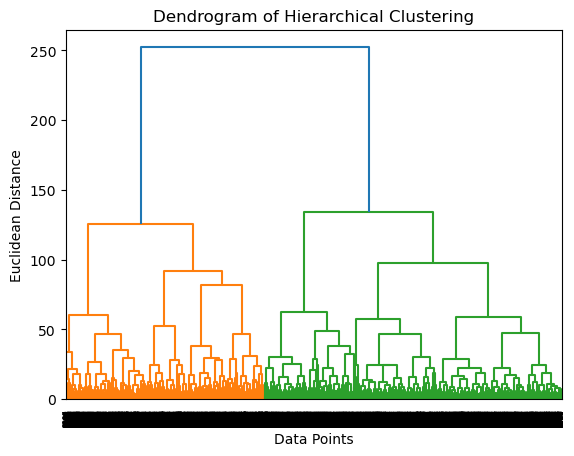

In [27]:
# Selecting only the columns with actual data
features = df.iloc[:, :5]

# Converting to a numpy array
data = features.to_numpy()

# Performing clustering
linkage_data = linkage(data, method='ward', metric='euclidean')

# Plotting the dendogram
dendrogram(linkage_data)
plt.title("Dendrogram of Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

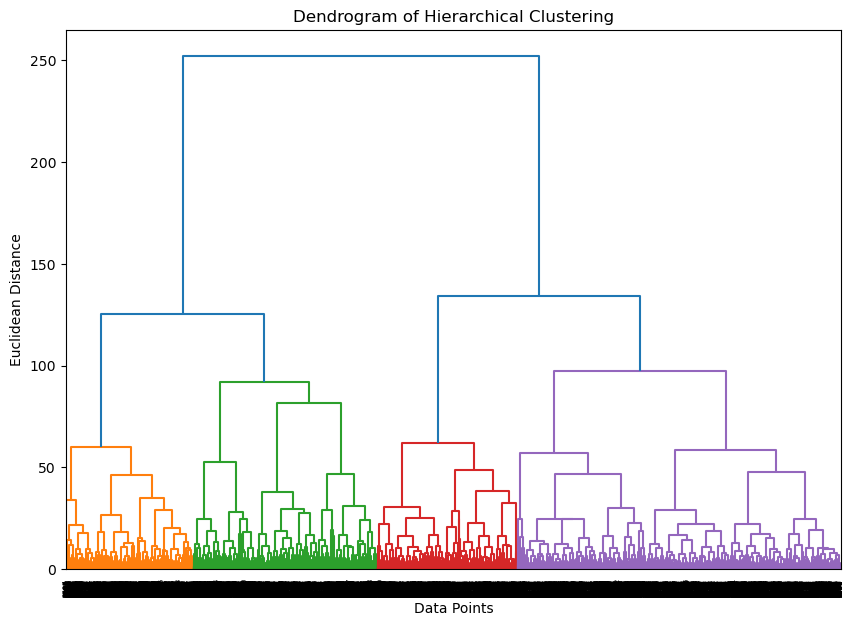

In [31]:
# Plotting the dendrogram with adjusted coloring
plt.figure(figsize=(10, 7))
dendrogram(linkage_data, color_threshold=0.4 * max(linkage_data[:, 2]))

plt.title("Dendrogram of Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

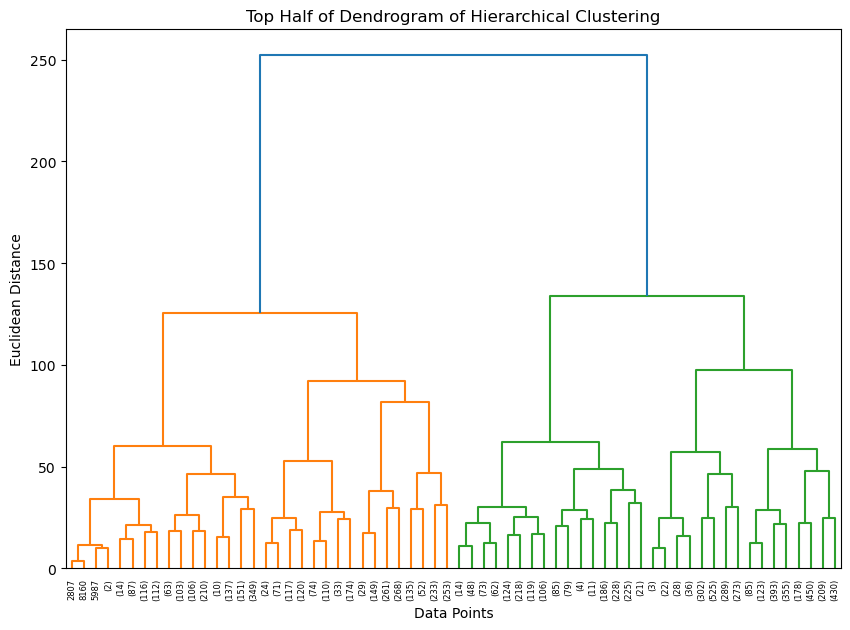

In [30]:
# Plotting a dendogram with only the top half of clusters for better view of individual clusters
plt.figure(figsize=(10, 7))

dendrogram(linkage_data, truncate_mode='level', p=5)

plt.title("Top Half of Dendrogram of Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()